# 1. Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, save_npz
import pickle
import seaborn as sns
from scipy.sparse import hstack

interactions = pd.read_csv('interactions.csv')
items = pd.read_csv('items.csv')
print('\nДАННЫЕ')
display(interactions.head())
print('\n\n' + '='*70)
print('\n\n')
display(items.head())


ДАННЫЕ


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [ ]:
display(interactions.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1594786 entries, 0 to 1594785
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   user_id        1594786 non-null  int64         
 1   item_id        1594786 non-null  int64         
 2   last_watch_dt  1594786 non-null  datetime64[ns]
 3   total_dur      1594786 non-null  float64       
 4   watched_pct    1594786 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 73.0 MB


None

In [ ]:
display(items.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


None

In [ ]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'], errors='coerce')
interactions = interactions.dropna(subset=['last_watch_dt'])
interactions['total_dur'] = interactions['total_dur'].fillna(0)
interactions['watched_pct'] = interactions['watched_pct'].fillna(0)

# mapping пользователей и элементов
user_ids = interactions['user_id'].unique()
item_ids = interactions['item_id'].unique()
user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
item_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}

In [ ]:
user_ids

array([176549, 699317, 656683, ..., 117143, 395195, 207142])

In [ ]:
item_ids

array([ 9506,  1659,  7107, ...,  1523,  2986, 11091])

In [ ]:
print(f"Всего записей: {len(interactions)}")
print(f"Пропуски в user_id: {interactions['user_id'].isnull().sum()}")
print(f"Пропуски в item_id: {interactions['item_id'].isnull().sum()}")
print(f"Уникальных пользователей: {interactions['user_id'].nunique()}")
print(f"Уникальных элементов: {interactions['item_id'].nunique()}")
print(f"Диапазон дат: от {interactions['last_watch_dt'].min()} до {interactions['last_watch_dt'].max()}")

Всего записей: 1594786
Пропуски в user_id: 0
Пропуски в item_id: 0
Уникальных пользователей: 567588
Уникальных элементов: 12693
Диапазон дат: от 2021-03-13 00:00:00 до 2021-08-22 00:00:00


In [ ]:
# продолжительность просмотров
print(f"Мин. продолжительность: {interactions['total_dur'].min()} сек")
print(f"Макс. продолжительность: {interactions['total_dur'].max()} сек")
print(f"Медианная продолжительность: {interactions['total_dur'].median()} сек")
print(f"Записи с нулевой продолжительностью: {(interactions['total_dur'] == 0).sum()}")

# процент просмотра
print(f"Мин. процент: {interactions['watched_pct'].min()}%")
print(f"Макс. процент: {interactions['watched_pct'].max()}%")
print(f"Медианный процент: {interactions['watched_pct'].median()}%")

Мин. продолжительность: 1.0 сек
Макс. продолжительность: 7241091.0 сек
Медианная продолжительность: 2900.0 сек
Записи с нулевой продолжительностью: 0
Мин. процент: 0.0%
Макс. процент: 100.0%
Медианный процент: 32.0%


# 2. Функция для создания и анализа матрицы

In [ ]:
def create_and_analyze_matrix(weights, name, bins=50):
    """Создает матрицу взаимодействий и анализирует ее"""
    print(f"\nАНАЛИЗ МЕТОДА: {name} ")

    # разреженная матрица
    row_indices = interactions['user_id'].map(user_to_index).values
    col_indices = interactions['item_id'].map(item_to_index).values

    matrix = csr_matrix((weights, (row_indices, col_indices)),
                       shape=(len(user_ids), len(item_ids)))


    print(f"Размерность матрицы: {matrix.shape}")
    print(f"Количество ненулевых элементов: {matrix.nnz}")
    density = matrix.nnz / (matrix.shape[0] * matrix.shape[1]) * 100
    print(f"Заполненность матрицы: {density:.6f}%")

    # распределение весов
    non_zero_weights = matrix.data
    print(f"Минимальный вес: {non_zero_weights.min():.6f}")
    print(f"Максимальный вес: {non_zero_weights.max():.6f}")
    print(f"Медианный вес: {np.median(non_zero_weights):.6f}")
    print(f"Средний вес: {non_zero_weights.mean():.6f}")

    plt.figure(figsize=(10, 6))
    plt.hist(non_zero_weights, bins=50, log=True)
    plt.title(f'Распределение весов: {name}')
    plt.xlabel('Вес')
    plt.ylabel('Частота (лог. шкала)')
    plt.show()

    # активность пользователей
    user_activity = np.array(matrix.sum(axis=1)).flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(user_activity, bins=bins, log=True)
    plt.title(f'Распределение активности пользователей: {name}')
    plt.xlabel('Суммарный вес')
    plt.ylabel('Количество пользователей (лог. шкала)')
    plt.show()

    item_popularity = np.array(matrix.sum(axis=0)).flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(item_popularity, bins=50, log=True)
    plt.title(f'Распределение популярности контента: {name}')
    plt.xlabel('Суммарный вес')
    plt.ylabel('Количество элементов (лог. шкала)')
    plt.show()

    return matrix

# 3. Реализация различных подходов кодирования
   
## 3.1. Бинарное кодирование

count
1    1594786
Name: count, dtype: int64
Создан бинарный вес: всегда 1 (всего записей: 1594786)

АНАЛИЗ МЕТОДА: Бинарное кодирование 
Размерность матрицы: (567588, 12693)
Количество ненулевых элементов: 1594786
Заполненность матрицы: 0.022136%
Минимальный вес: 1.000000
Максимальный вес: 1.000000
Медианный вес: 1.000000
Средний вес: 1.000000


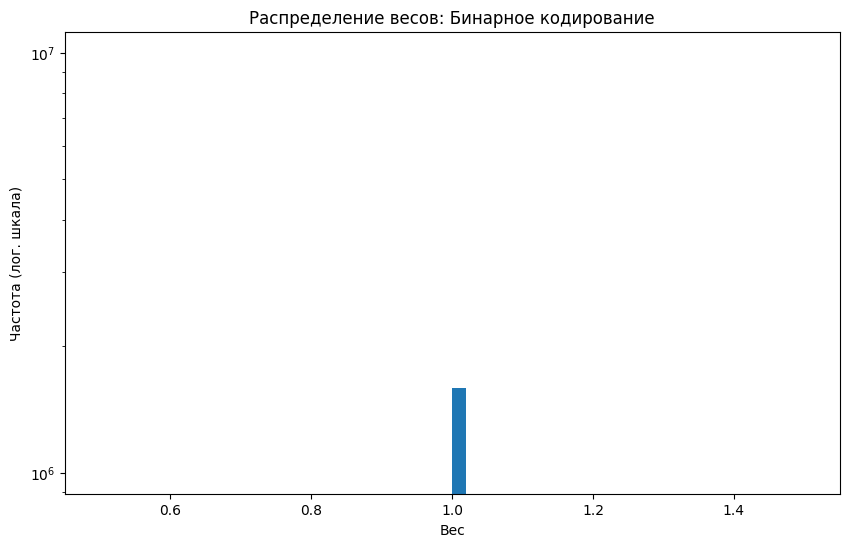

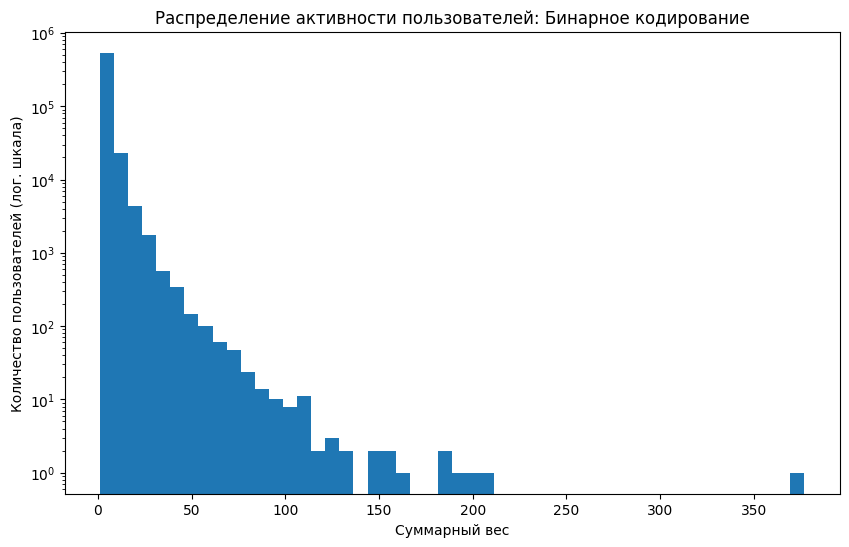

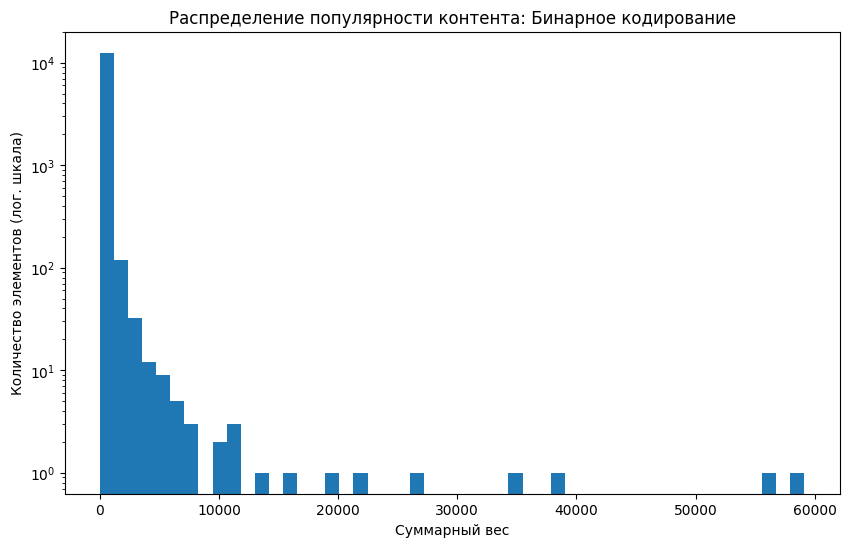

In [ ]:
# наличие дубликатов только для информации
duplicate_check = interactions.groupby(['user_id', 'item_id']).size().reset_index(name='count')
duplicate_counts = duplicate_check['count'].value_counts()

print(duplicate_counts)

# бинарное кодирование ВСЕГДА равно 1 для любой пары
interactions['binary_weight'] = 1
print(f"Создан бинарный вес: всегда 1 (всего записей: {len(interactions)})")

binary_matrix = create_and_analyze_matrix(interactions['binary_weight'].values, "Бинарное кодирование")

In [ ]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,binary_weight
0,176549,9506,2021-05-11,4250.0,72.0,1
1,699317,1659,2021-05-29,8317.0,100.0,1
2,656683,7107,2021-05-09,10.0,0.0,1
3,864613,7638,2021-07-05,14483.0,100.0,1
4,964868,9506,2021-04-30,6725.0,100.0,1


## 3.2. Частотное кодирование


АНАЛИЗ МЕТОДА: Частотное кодирование 
Размерность матрицы: (567588, 12693)
Количество ненулевых элементов: 1594786
Заполненность матрицы: 0.022136%
Минимальный вес: 1.000000
Максимальный вес: 1.000000
Медианный вес: 1.000000
Средний вес: 1.000000


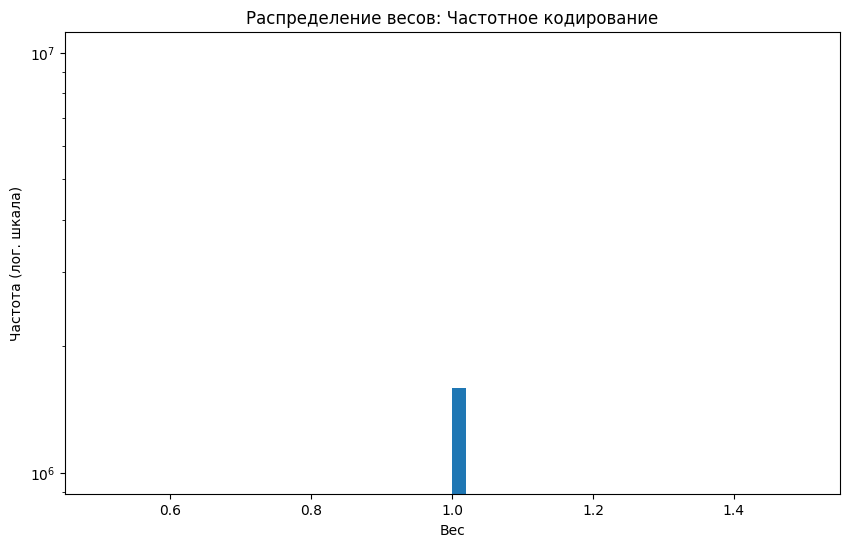

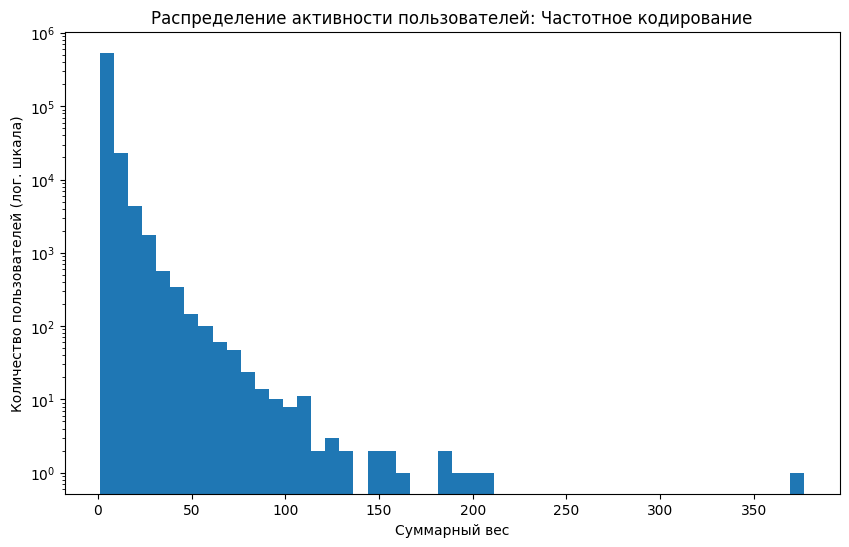

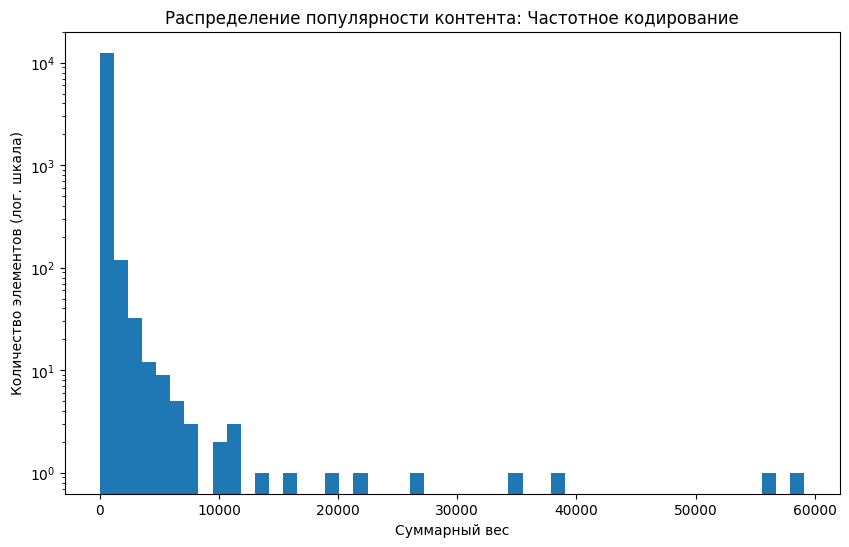


АНАЛИЗ МЕТОДА: Частотное кодирование (лог) 
Размерность матрицы: (567588, 12693)
Количество ненулевых элементов: 1594786
Заполненность матрицы: 0.022136%
Минимальный вес: 0.693147
Максимальный вес: 0.693147
Медианный вес: 0.693147
Средний вес: 0.693147


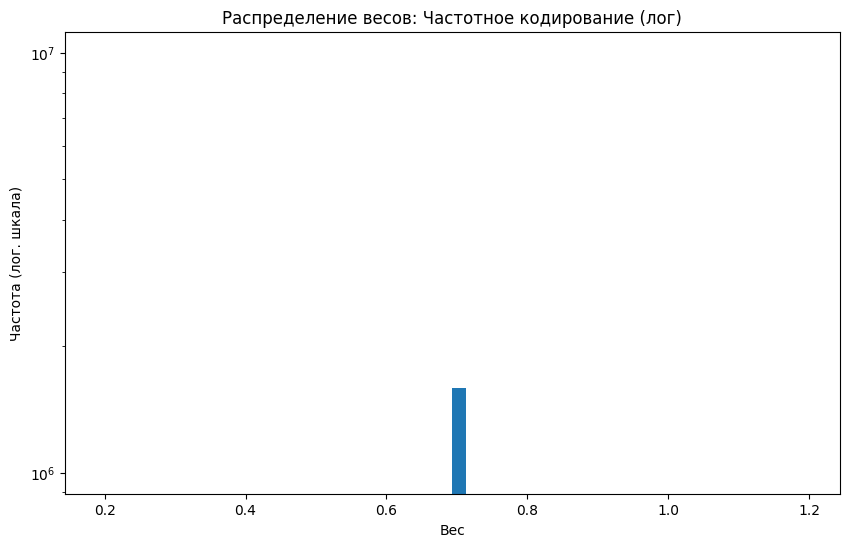

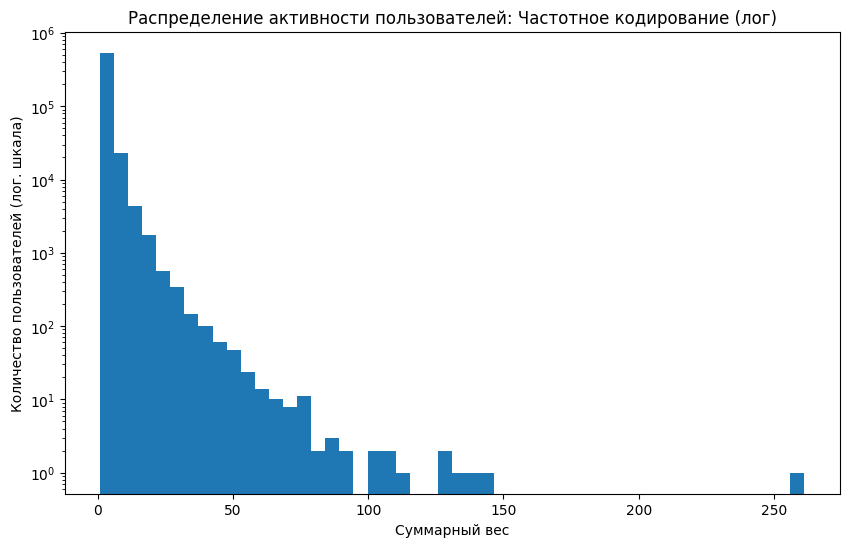

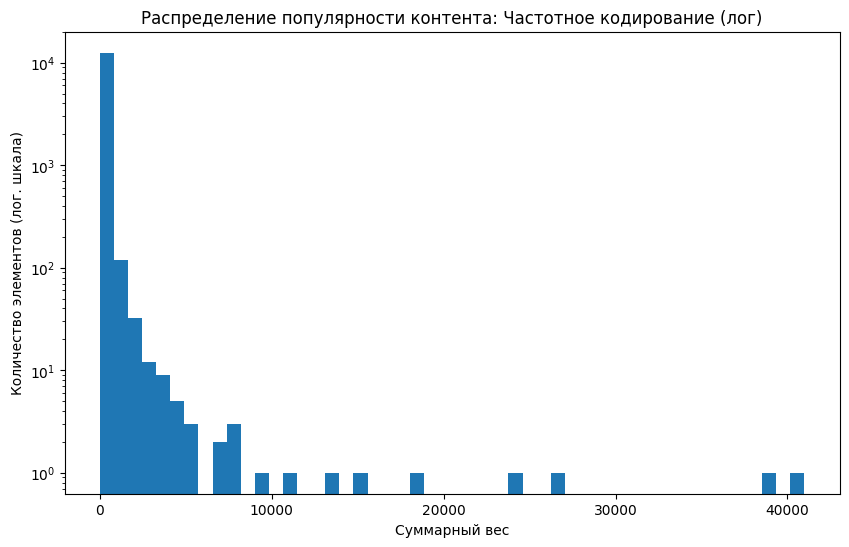

In [ ]:
# количество взаимодействий для каждой пары пользователь-элемент
freq_weights = interactions.groupby(['user_id', 'item_id']).size()
freq_weights = freq_weights.reindex(pd.MultiIndex.from_arrays([interactions['user_id'], interactions['item_id']])).fillna(0).values

frequency_matrix = create_and_analyze_matrix(freq_weights, "Частотное кодирование")

# логарифмирование
freq_weights_log = np.log1p(freq_weights)
frequency_matrix_log = create_and_analyze_matrix(freq_weights_log, "Частотное кодирование (лог)")

save_npz('frequency_matrix.npz', frequency_matrix)
save_npz('frequency_matrix_log.npz', frequency_matrix_log)

## 3.3. Временное кодирование


АНАЛИЗ МЕТОДА: Временное кодирование 
Размерность матрицы: (567588, 12693)
Количество ненулевых элементов: 1594786
Заполненность матрицы: 0.022136%
Минимальный вес: 0.023683
Максимальный вес: 1.000000
Медианный вес: 0.293887
Средний вес: 0.372824


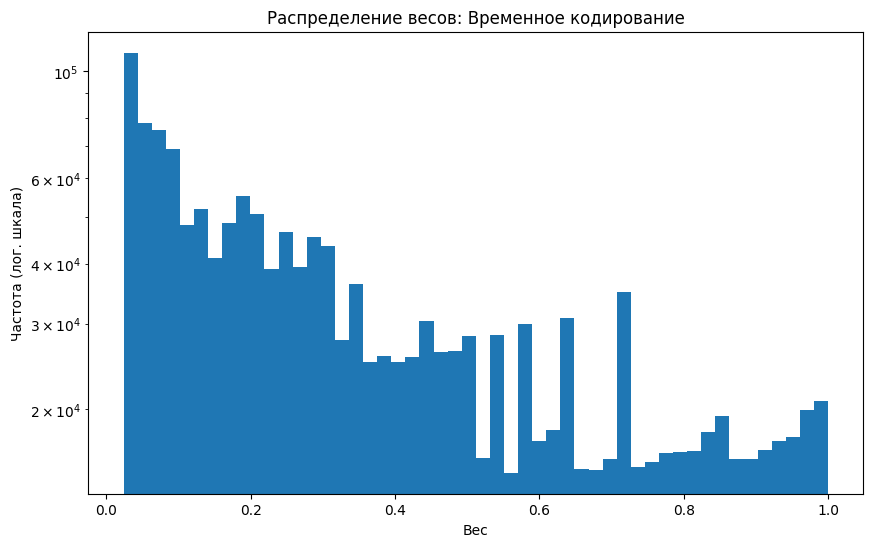

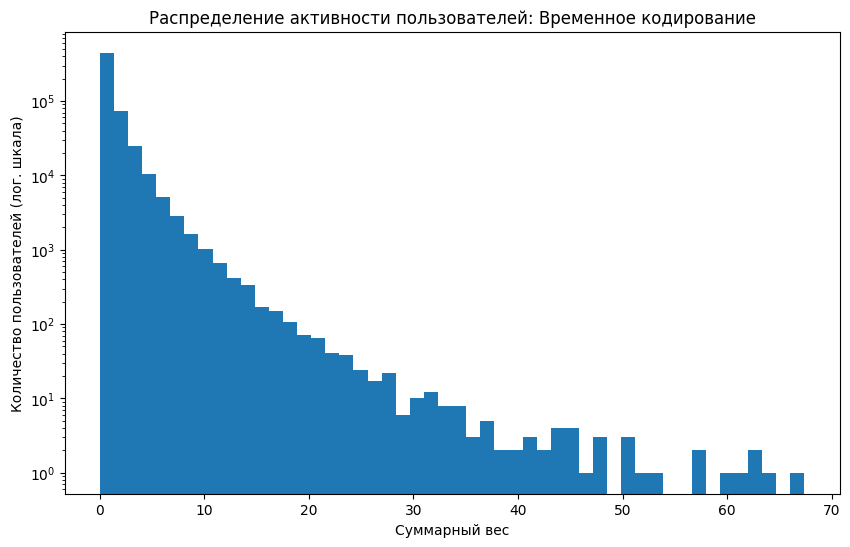

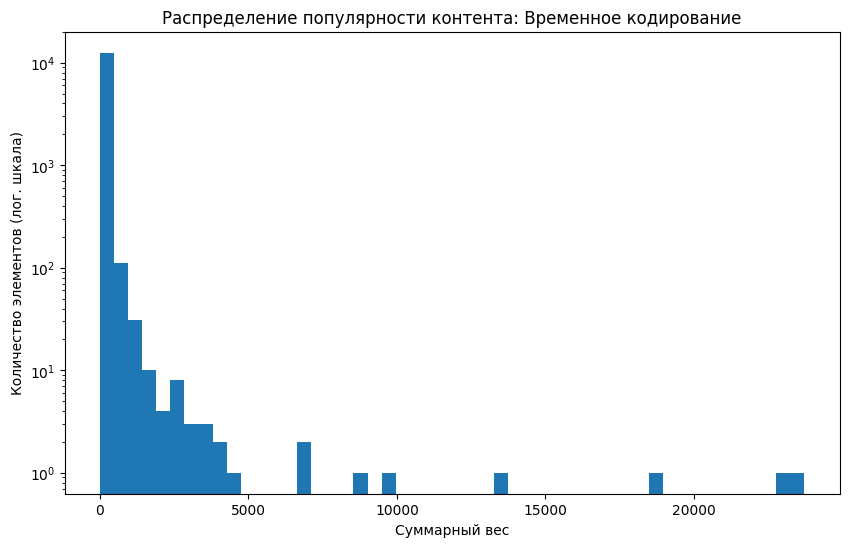

In [ ]:
# экспоненциальное затухание веса со временем
current_date = interactions['last_watch_dt'].max()
interactions['days_since_watch'] = (current_date - interactions['last_watch_dt']).dt.days
half_life = 30  # период полураспада в днях
interactions['time_decay_weight'] = np.exp(-np.log(2) * interactions['days_since_watch'] / half_life)

time_matrix = create_and_analyze_matrix(interactions['time_decay_weight'].values, "Временное кодирование")

save_npz('time_matrix.npz', time_matrix)

## 3.4. Кодирование завершенности просмотра


АНАЛИЗ МЕТОДА: Кодирование завершенности 
Размерность матрицы: (567588, 12693)
Количество ненулевых элементов: 1594786
Заполненность матрицы: 0.022136%
Минимальный вес: 0.100000
Максимальный вес: 1.000000
Медианный вес: 0.600000
Средний вес: 0.544061


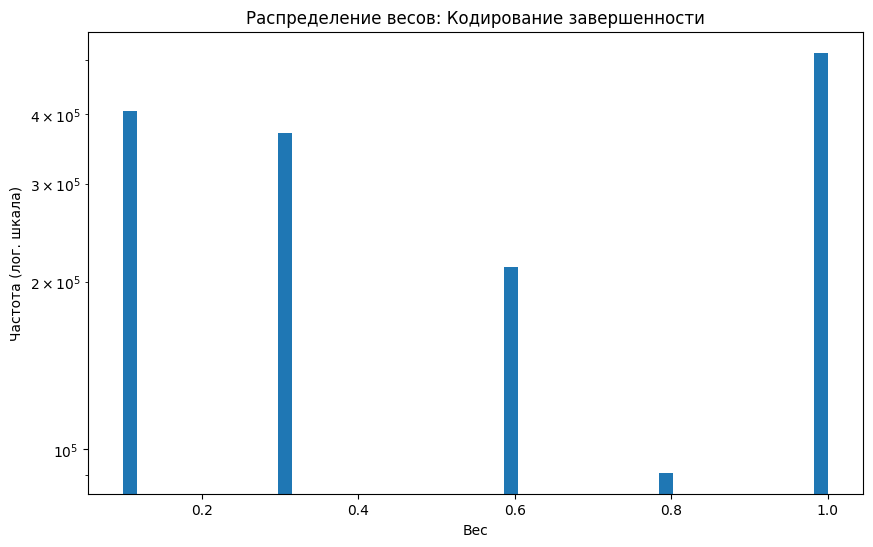

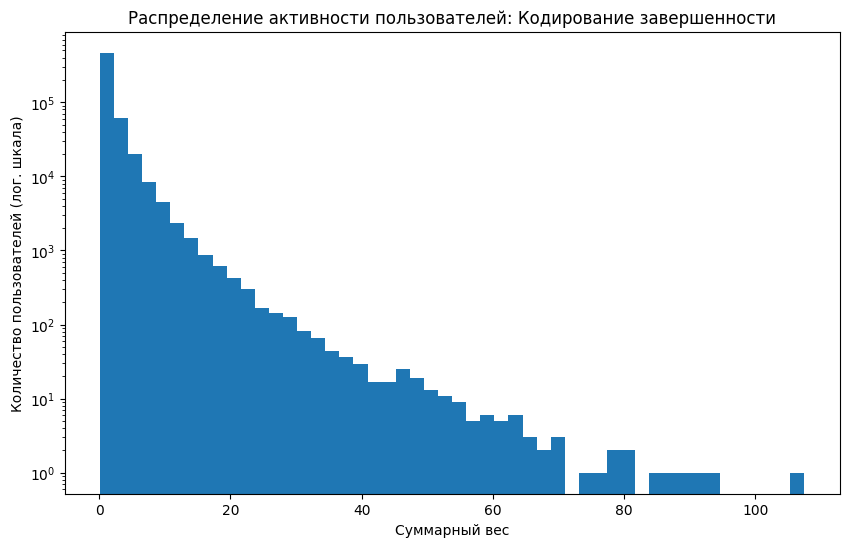

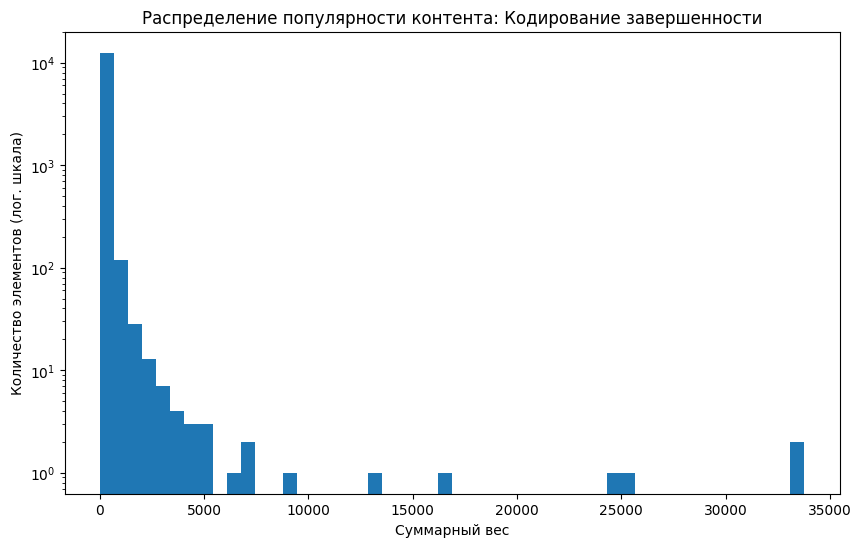

In [ ]:
# нелинейное преобразование процента просмотра
def completion_transform(pct):
    if pct < 5: return 0.1  # почти не смотрел
    elif pct < 30: return 0.3  # немного посмотрел
    elif pct < 70: return 0.6  # посмотрел значительную часть
    elif pct < 90: return 0.8  # почти досмотрел
    else: return 1.0  # полностью посмотрел

interactions['completion_weight'] = interactions['watched_pct'].apply(completion_transform)

completion_matrix = create_and_analyze_matrix(interactions['completion_weight'].values, "Кодирование завершенности")

save_npz('completion_matrix.npz', completion_matrix)

In [ ]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,binary_weight,days_since_watch,time_decay_weight,completion_weight
0,176549,9506,2021-05-11,4250.0,72.0,1,103,0.092569,0.8
1,699317,1659,2021-05-29,8317.0,100.0,1,85,0.140308,1.0
2,656683,7107,2021-05-09,10.0,0.0,1,105,0.088388,0.1
3,864613,7638,2021-07-05,14483.0,100.0,1,48,0.329877,1.0
4,964868,9506,2021-04-30,6725.0,100.0,1,114,0.071794,1.0


3.5. Комбинированное кодирование


АНАЛИЗ МЕТОДА: Комбинированное кодирование 
Размерность матрицы: (567588, 12693)
Количество ненулевых элементов: 1594786
Заполненность матрицы: 0.022136%
Минимальный вес: 0.000000
Максимальный вес: 1.000000
Медианный вес: 0.160108
Средний вес: 0.355902


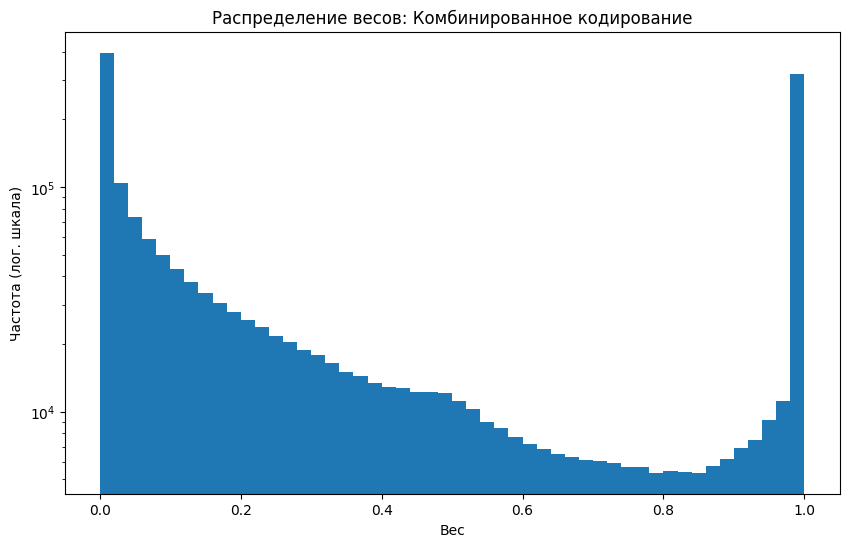

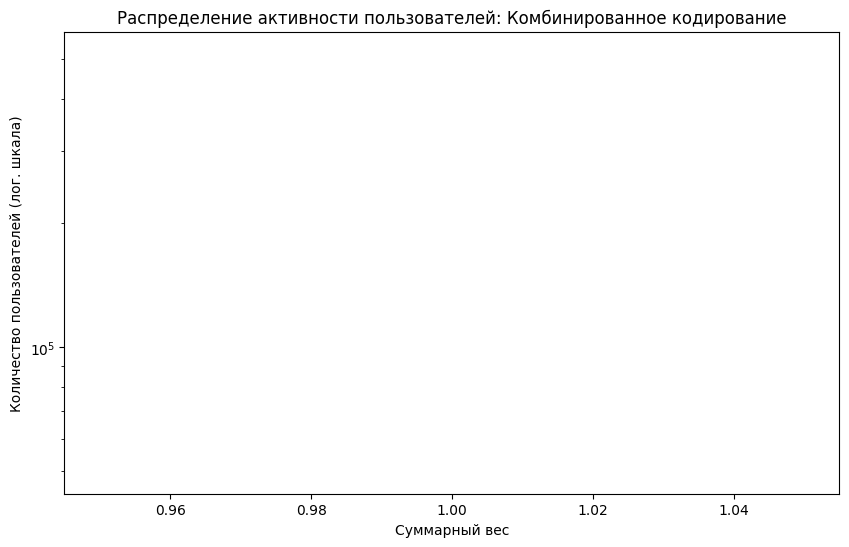

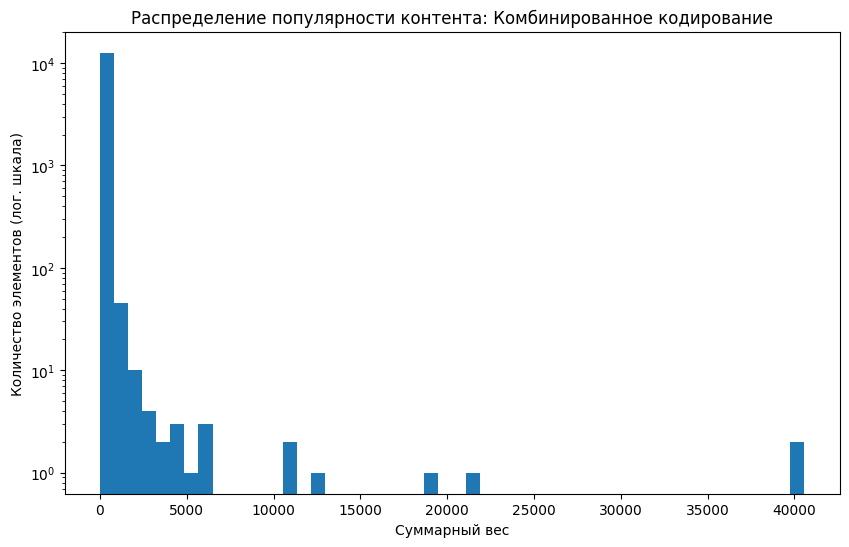

In [ ]:
# комбинируем несколько факторов
interactions['combined_weight'] = (
    interactions['time_decay_weight'] *
    interactions['completion_weight'] *
    np.log1p(interactions['total_dur'] / 3600)  # продолжительность в часах
)

# нормализуем веса для каждого пользователя
user_weights = interactions.groupby('user_id')['combined_weight'].transform('sum')
interactions['normalized_weight'] = interactions['combined_weight'] / user_weights
interactions['normalized_weight'] = interactions['normalized_weight'].fillna(0)

combined_matrix = create_and_analyze_matrix(interactions['normalized_weight'].values, "Комбинированное кодирование", bins=2)

save_npz('combined_matrix.npz', combined_matrix)

## 3.6. Кодирование на основе типа контента

In [ ]:
items[['item_id', 'content_type']]

,item_id,content_type
0,10711,film
1,2508,film
2,10716,film
3,7868,film
4,16268,film
...,...,...
15958,6443,series
15959,2367,series
15960,10632,series
15961,4538,series



АНАЛИЗ МЕТОДА: Кодирование на основе типа контента 
Размерность матрицы: (567588, 12693)
Количество ненулевых элементов: 1594786
Заполненность матрицы: 0.022136%
Минимальный вес: 0.000000
Максимальный вес: 1.200000
Медианный вес: 0.165057
Средний вес: 0.378915


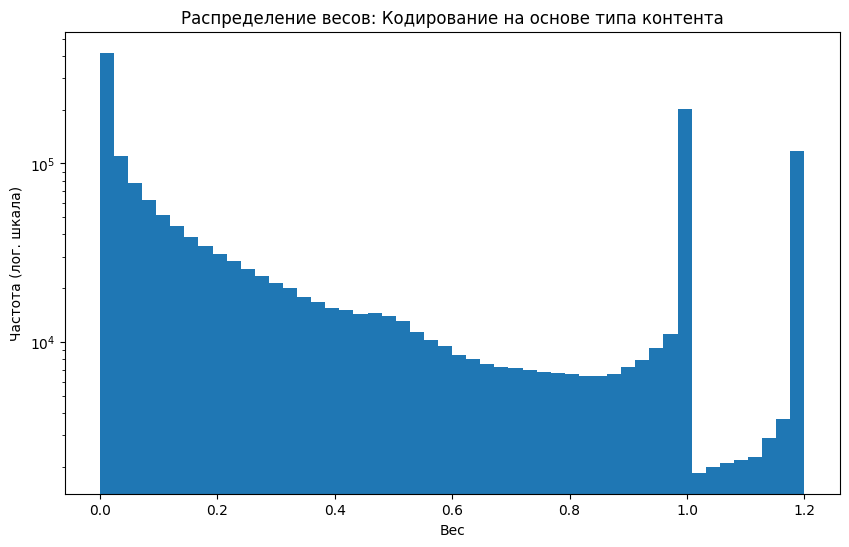

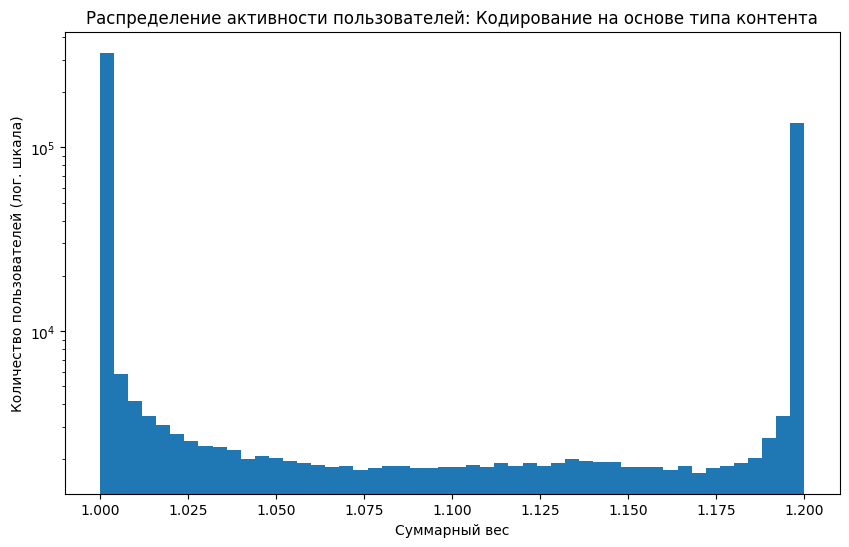

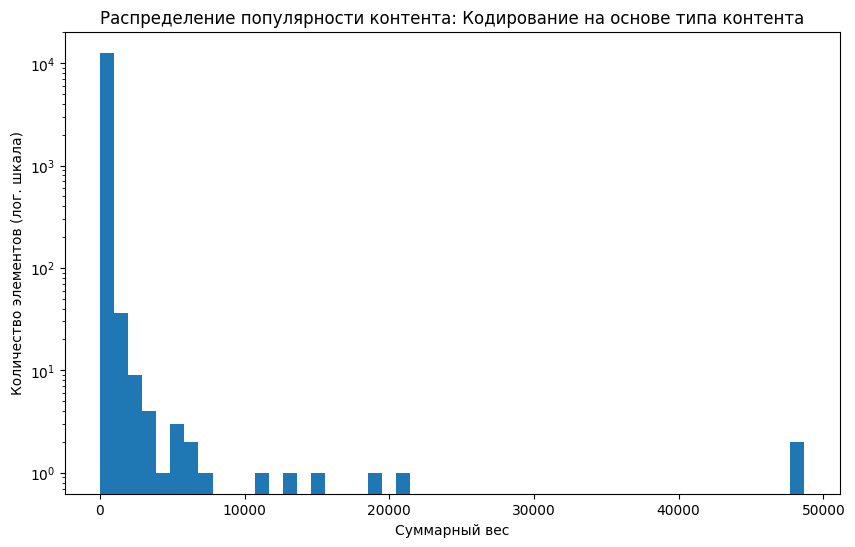

In [ ]:
# информация о типе контента
interactions_with_items = interactions.merge(
    items[['item_id', 'content_type']],
    on='item_id',
    how='left'
)

# разные веса для разных типов контента
content_weights = {
    'film': 1.0,
    'series': 1.2,
    'cartoon': 0.9,
    'documentary': 0.8
}

interactions_with_items['content_weight'] = interactions_with_items['content_type'].map(
    lambda x: content_weights.get(x, 1.0)
)

interactions_with_items['content_aware_weight'] = (
    interactions_with_items['normalized_weight'] *
    interactions_with_items['content_weight']
)

content_matrix = create_and_analyze_matrix(interactions_with_items['content_aware_weight'].values, "Кодирование на основе типа контента")

save_npz('content_matrix.npz', content_matrix)

# Кодирование на основе кластеризации

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# профили пользователей: каждого пользователя агрегируем все его взаимодействия
user_profiles = interactions.groupby('user_id').agg({
    'total_dur': 'sum',           # общая длительность просмотров
    'watched_pct': 'mean',        # средний процент просмотра
    'days_since_watch': 'min',    # как давно был последний просмотр (min, т.к. мы считали дни)
    'item_id': 'count'            # количество уникальных просмотров (активность)
}).rename(columns={'item_id': 'view_count'})

scaler = StandardScaler()
user_profiles_scaled = scaler.fit_transform(user_profiles)


n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
user_clusters = kmeans.fit_predict(user_profiles_scaled)

user_profiles['cluster'] = user_clusters
print("\nХАРАКТЕРИСТИКИ КЛАСТЕРОВ:")
print(user_profiles.groupby('cluster').mean())


ХАРАКТЕРИСТИКИ КЛАСТЕРОВ:
             total_dur  watched_pct  days_since_watch  view_count
cluster                                                          
0          5715.263060    17.318450        103.252301    1.644088
1         26310.014124    82.844244         53.433866    2.090152
2        103405.373454    54.512631         21.490224   12.251556
3        707406.542178    62.412349         24.791683   18.266931
4          9276.072626    20.447362         22.970823    2.229184



АНАЛИЗ МЕТОДА: Кодирование на основе кластеризации 
Размерность матрицы: (567588, 12693)
Количество ненулевых элементов: 1594786
Заполненность матрицы: 0.022136%
Минимальный вес: 0.000000
Максимальный вес: 1.400000
Медианный вес: 0.177434
Средний вес: 0.347944


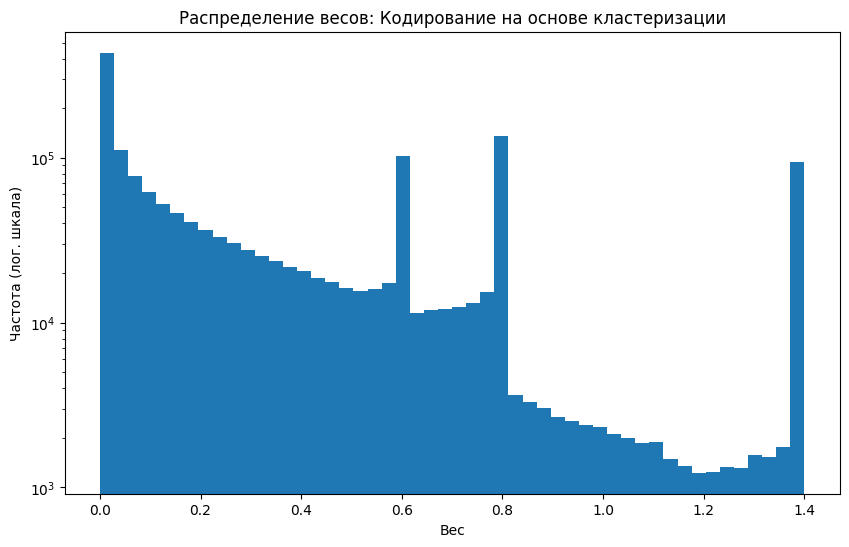

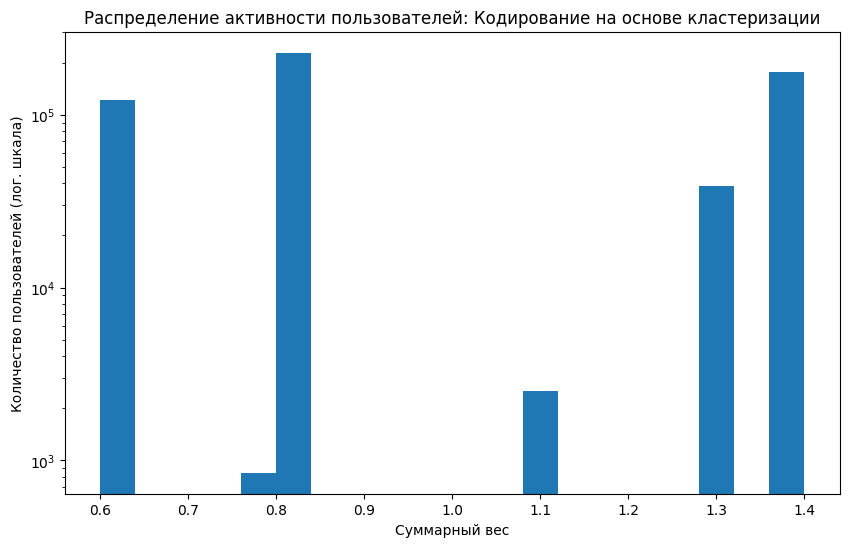

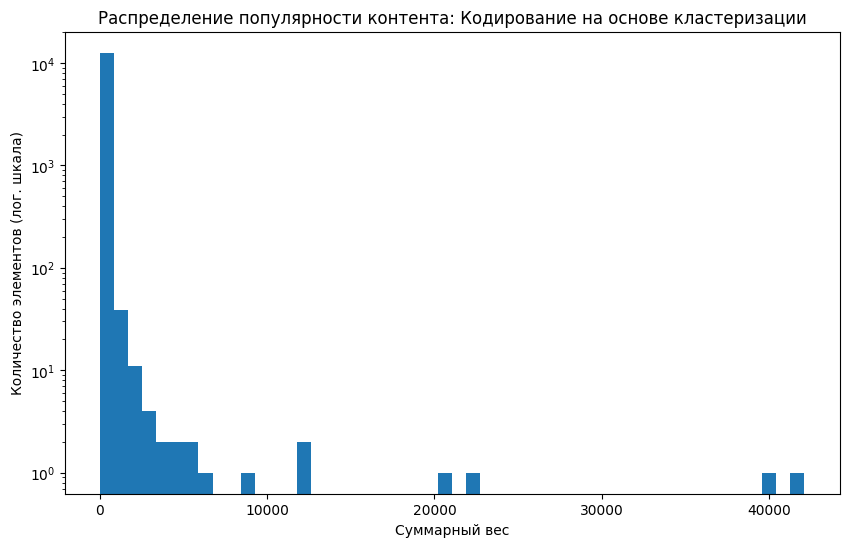

In [ ]:
# добавляем информацию о кластере обратно в DataFrame interactions
cluster_map = user_profiles['cluster'].to_dict()
interactions['user_cluster'] = interactions['user_id'].map(cluster_map)

# кластер как один из факторов веса
# пользователям из "активного" кластера можно повысить вес их действий
cluster_weights = {
    0: 0.6,  # низкая активность (худшие показатели)
    1: 1.4,  # высокое качество (лучшая завершенность 82.8%)
    2: 1.3,  # активные (много просмотров, недавняя активность)
    3: 1.1,  # серийные маньяки (огромная длительность, но среднее качество)
    4: 0.8   # случайные (низкое качество, но недавняя активность)
}
# веса в зависимости от кластера
interactions['cluster_weight'] = interactions['user_cluster'].map(cluster_weights)

# объединяем с предыдущими весами
interactions['cluster_aware_weight'] = interactions['normalized_weight'] * interactions['cluster_weight']

cluster_matrix = create_and_analyze_matrix(interactions['cluster_aware_weight'].values,
                                          "Кодирование на основе кластеризации", bins=20)

save_npz('cluster_matrix.npz', cluster_matrix)

## 4. Сравнительный анализ

СРАВНИТЕЛЬНЫЙ АНАЛИЗ МЕТОДОВ КОДИРОВАНИЯ


,Метод,Размерность,Ненулевых элементов,Заполненность (%),Мин. вес,Макс. вес,Мед. вес,Ср. вес,Мед. активность пользователей,Мед. популярность контента
0,Бинарное кодирование,567588x12693,1594786,0.022136,1.000000,1.000000,1.000000,1.000000,2.000000,7.000000
1,Частотное кодирование,567588x12693,1594786,0.022136,1.000000,1.000000,1.000000,1.000000,2.000000,7.000000
2,Частотное кодирование (лог),567588x12693,1594786,0.022136,0.693147,0.693147,0.693147,0.693147,1.386294,4.852030
3,Временное кодирование,567588x12693,1594786,0.022136,0.023683,1.000000,0.293887,0.372824,0.581877,1.939510
4,Кодирование завершенности,567588x12693,1594786,0.022136,0.100000,1.000000,0.600000,0.544061,0.900000,3.700000
5,Комбинированное кодирование,567588x12693,1594786,0.022136,0.000000,1.000000,0.160108,0.355902,1.000000,1.491381
6,Кодирование на основе типа контента,567588x12693,1594786,0.022136,0.000000,1.200000,0.165057,0.378915,1.000000,1.545920
7,Кодирование на основе кластеризации,567588x12693,1594786,0.022136,0.000000,1.400000,0.177434,0.347944,0.800000,1.475995


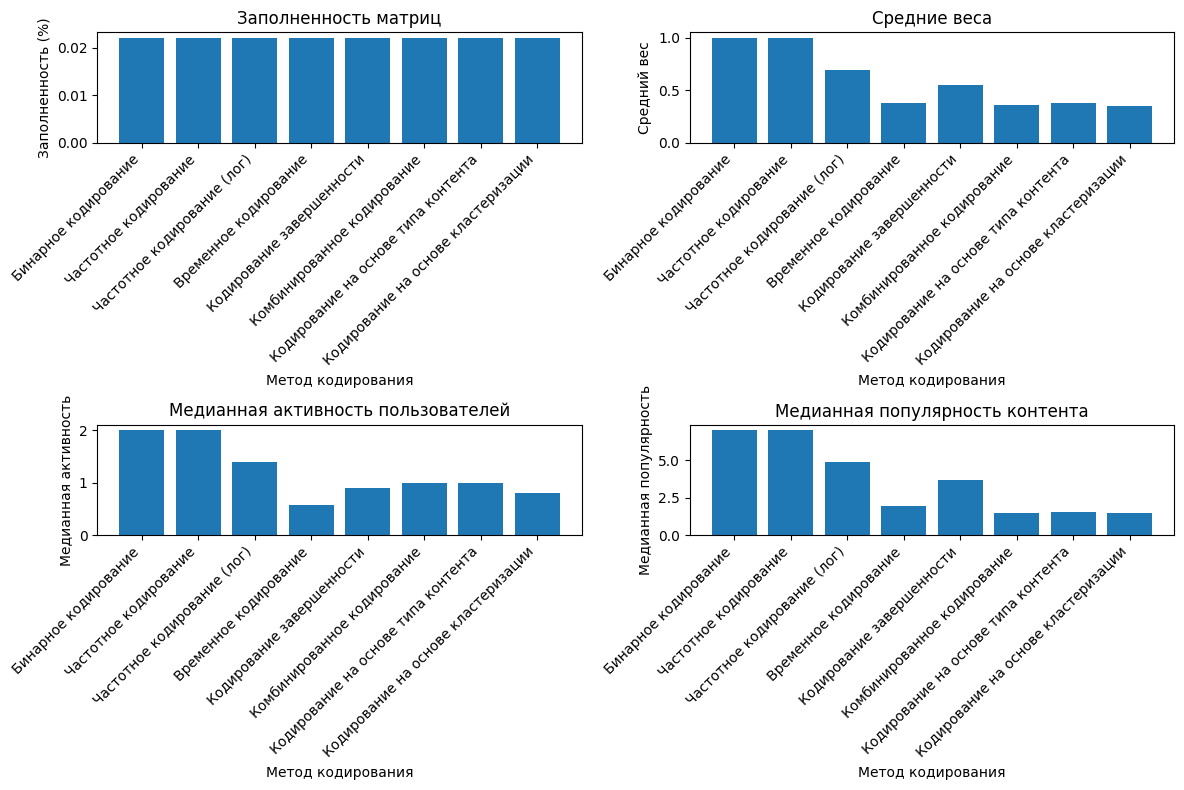

In [ ]:
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ МЕТОДОВ КОДИРОВАНИЯ")

# таблица для сравнения методов
methods = [
    "Бинарное кодирование",
    "Частотное кодирование",
    "Частотное кодирование (лог)",
    "Временное кодирование",
    "Кодирование завершенности",
    "Комбинированное кодирование",
    "Кодирование на основе типа контента",
    "Кодирование на основе кластеризации"
]

matrices = [
    binary_matrix,
    frequency_matrix,
    frequency_matrix_log,
    time_matrix,
    completion_matrix,
    combined_matrix,
    content_matrix,
    cluster_matrix
]


comparison_data = []

for name, matrix in zip(methods, matrices):
    non_zero_weights = matrix.data
    user_activity = np.array(matrix.sum(axis=1)).flatten()
    item_popularity = np.array(matrix.sum(axis=0)).flatten()

    comparison_data.append({
        'Метод': name,
        'Размерность': f"{matrix.shape[0]}x{matrix.shape[1]}",
        'Ненулевых элементов': matrix.nnz,
        'Заполненность (%)': f"{matrix.nnz / (matrix.shape[0] * matrix.shape[1]) * 100:.6f}",
        'Мин. вес': f"{non_zero_weights.min():.6f}",
        'Макс. вес': f"{non_zero_weights.max():.6f}",
        'Мед. вес': f"{np.median(non_zero_weights):.6f}",
        'Ср. вес': f"{non_zero_weights.mean():.6f}",
        'Мед. активность пользователей': f"{np.median(user_activity):.6f}",
        'Мед. популярность контента': f"{np.median(item_popularity):.6f}"
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
density_values = [float(x['Заполненность (%)']) for x in comparison_data]
plt.bar(methods, density_values)
plt.title('Заполненность матриц')
plt.xlabel('Метод кодирования')
plt.ylabel('Заполненность (%)')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 2)
mean_values = [float(x['Ср. вес']) for x in comparison_data]
plt.bar(methods, mean_values)
plt.title('Средние веса')
plt.xlabel('Метод кодирования')
plt.ylabel('Средний вес')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 3)
activity_values = [float(x['Мед. активность пользователей']) for x in comparison_data]
plt.bar(methods, activity_values)
plt.title('Медианная активность пользователей')
plt.xlabel('Метод кодирования')
plt.ylabel('Медианная активность')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 4)
popularity_values = [float(x['Мед. популярность контента']) for x in comparison_data]
plt.bar(methods, popularity_values)
plt.title('Медианная популярность контента')
plt.xlabel('Метод кодирования')
plt.ylabel('Медианная популярность')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
weights_df = pd.DataFrame({
    'binary': interactions['binary_weight'],
    'frequency': freq_weights,
    'time_decay': interactions['time_decay_weight'],
    'completion': interactions['completion_weight'],
    'combined': interactions['normalized_weight'].fillna(0)
})

weights_df['content_aware'] = interactions_with_items['content_aware_weight'].fillna(0)
weights_df['cluster_aware'] = interactions['cluster_aware_weight'].fillna(0)


correlation_matrix = weights_df.corr()
correlation_matrix

,binary,frequency,time_decay,completion,combined,content_aware,cluster_aware
binary,NaN,NaN,NaN,NaN,NaN,NaN,NaN
frequency,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_decay,NaN,NaN,1.000000,-0.081107,0.078673,0.079701,0.096242
completion,NaN,NaN,-0.081107,1.000000,0.137853,0.120441,0.326801
combined,NaN,NaN,0.078673,0.137853,1.000000,0.992908,0.903772
content_aware,NaN,NaN,0.079701,0.120441,0.992908,1.000000,0.894353
cluster_aware,NaN,NaN,0.096242,0.326801,0.903772,0.894353,1.000000


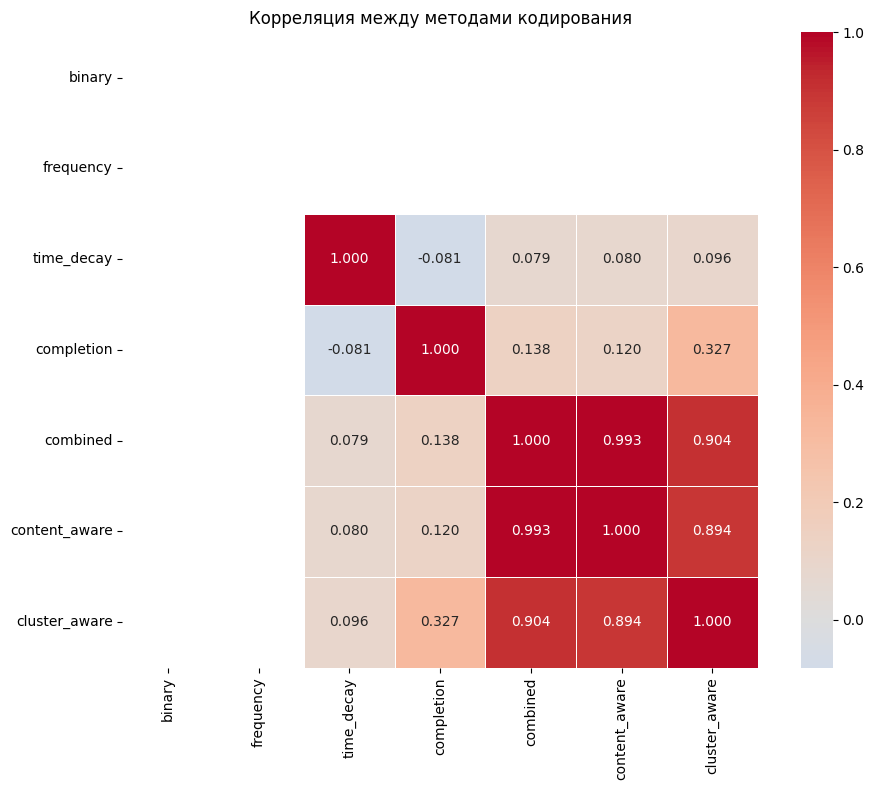

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', linewidths=0.5)
plt.title('Корреляция между методами кодирования')
plt.tight_layout()
plt.show()

          ┌────────────────────────────────────────┐
          │         РЕАЛЬНЫЕ КОРРЕЛЯЦИИ            │
          │                                        │
          │  ┌─────────────────┐                   │
          │  │  КОМБИНИРОВАННЫЙ│                   │
          │  │  + КОНТЕНТ      │ r=0.993 ◄───┐     │
          │  │  + КЛАСТЕРИЗАЦИЯ│ r=0.948 ◄───┼─────┘
          │  └─────────────────┘             │
          │                                  │
          │  ┌─────────────┐                 │ r=0.138 (СЛАБАЯ)
          │  │ЗАВЕРШЁННОСТЬ│◄────────────────┘
          │  └─────────────┘                 │ r=-0.081 (НУЛЕВАЯ)
          │                                  │
          │  ┌─────────────┐                 │
          │  │   ВРЕМЯ     │◄────────────────┘ r=0.079 (НУЛЕВАЯ)
          │  └─────────────┘
          │
          │  ┌─────────────┐  БИНАРНЫЙ и ЧАСТОТНЫЙ
          │  │   NaN       │  ← ТЕХНИЧЕСКАЯ ПРОБЛЕМА
          │  └─────────────┘
          └────────────────────────────────────────┘

In [ ]:
existing_matrices = {
    'binary': binary_matrix,
    'frequency': frequency_matrix,
    'frequency_log': frequency_matrix_log,
    'time_decay': time_matrix,
    'completion': completion_matrix,
    'combined': combined_matrix,
    'content_aware': content_matrix,
    'cluster_aware': cluster_matrix
}

print("ВСЕ матрицы уже созданы и сохранены!")

ВСЕ матрицы уже созданы и сохранены!


# На основе корреляционного анализа выбираем оптимальные матрицы

In [ ]:
optimal_matrices = {
    'time_decay': time_matrix,           # временная информация
    'completion': completion_matrix,     # информация о глубине
    'combined': combined_matrix          # комплексный подход
}

for name, matrix in optimal_matrices.items():
    print(f" {name}: {matrix.shape}, ненулевых: {matrix.nnz}")

 time_decay: (567588, 12693), ненулевых: 1594786
 completion: (567588, 12693), ненулевых: 1594786
 combined: (567588, 12693), ненулевых: 1594786


# Финальный сравнительный анализ оптимальных методов

In [ ]:
optimal_methods = ["Временное", "Завершенность", "Комбинированное"]
optimal_data = []

for name, matrix in optimal_matrices.items():
    non_zero_weights = matrix.data
    user_activity = np.array(matrix.sum(axis=1)).flatten()
    item_popularity = np.array(matrix.sum(axis=0)).flatten()

    optimal_data.append({
        'Метод': name,
        'Размерность': f"{matrix.shape[0]}x{matrix.shape[1]}",
        'Ненулевых': matrix.nnz,
        'Заполненность (%)': f"{matrix.nnz / (matrix.shape[0] * matrix.shape[1]) * 100:.6f}",
        'Мин. вес': f"{non_zero_weights.min():.6f}",
        'Макс. вес': f"{non_zero_weights.max():.6f}",
        'Мед. вес': f"{np.median(non_zero_weights):.6f}",
        'Ср. вес': f"{non_zero_weights.mean():.6f}",
        'Мед. активность': f"{np.median(user_activity):.6f}",
        'Мед. популярность': f"{np.median(item_popularity):.6f}"
    })

optimal_df = pd.DataFrame(optimal_data)
display(optimal_df)

,Метод,Размерность,Ненулевых,Заполненность (%),Мин. вес,Макс. вес,Мед. вес,Ср. вес,Мед. активность,Мед. популярность
0,time_decay,567588x12693,1594786,0.022136,0.023683,1.000000,0.293887,0.372824,0.581877,1.939510
1,completion,567588x12693,1594786,0.022136,0.100000,1.000000,0.600000,0.544061,0.900000,3.700000
2,combined,567588x12693,1594786,0.022136,0.000000,1.000000,0.160108,0.355902,1.000000,1.491381


#  Создание финального индекс-файла

In [ ]:
index_info = {
    'project': 'KION Dataset Matrix Encoding',
    'timestamp': pd.Timestamp.now(),
    'matrices_available': list(existing_matrices.keys()),
    'optimal_selection': list(optimal_matrices.keys()),
    'correlation_insights': {
        'time_completion_independent': True,
        'time_completion_correlation': -0.081,
    },
    'matrix_details': {
        name: {
            'shape': matrix.shape,
            'nnz': matrix.nnz,
            'density': f"{(matrix.nnz / (matrix.shape[0] * matrix.shape[1]) * 100):.6f}%"
        }
        for name, matrix in existing_matrices.items()
    }
}


with open('matrix_index.pkl', 'wb') as f:
    pickle.dump(index_info, f)

print("Индекс-файл создан: matrix_index.pkl")

Индекс-файл создан: matrix_index.pkl


# Создание объединенной матрицы признаков:

In [ ]:
# разреженные матрицы для каждого метода
row_indices = interactions['user_id'].map(user_to_index).values
col_indices = interactions['item_id'].map(item_to_index).values

# матрица с тремя измерениями признаков
time_weights = interactions['time_decay_weight'].values
completion_weights = interactions['completion_weight'].values
combined_weights = interactions['normalized_weight'].fillna(0).values

# многомерная матрицу (user × item × features)
time_csr = csr_matrix((time_weights, (row_indices, col_indices)),
                      shape=(len(user_ids), len(item_ids)))

completion_csr = csr_matrix((completion_weights, (row_indices, col_indices)),
                           shape=(len(user_ids), len(item_ids)))

combined_csr = csr_matrix((combined_weights, (row_indices, col_indices)),
                         shape=(len(user_ids), len(item_ids)))

# объединяем по горизонтали (каждый признак - отдельный столбец)
multi_feature_matrix = hstack([time_csr, completion_csr, combined_csr])
print(f"Размерность объединенной матрицы: {multi_feature_matrix.shape}")
print(f"Признаки: [время, завершенность, комбинированный]")

save_npz('multi_feature_matrix.npz', multi_feature_matrix)

Размерность объединенной матрицы: (567588, 38079)
Признаки: [время, завершенность, комбинированный]


# Матрица с взвешенной комбинацией


АНАЛИЗ МЕТОДА: Взвешенная комбинация методов 
Размерность матрицы: (567588, 12693)
Количество ненулевых элементов: 1594786
Заполненность матрицы: 0.022136%
Минимальный вес: 0.112969
Максимальный вес: 2.283445
Медианный вес: 1.017019
Средний вес: 1.000000


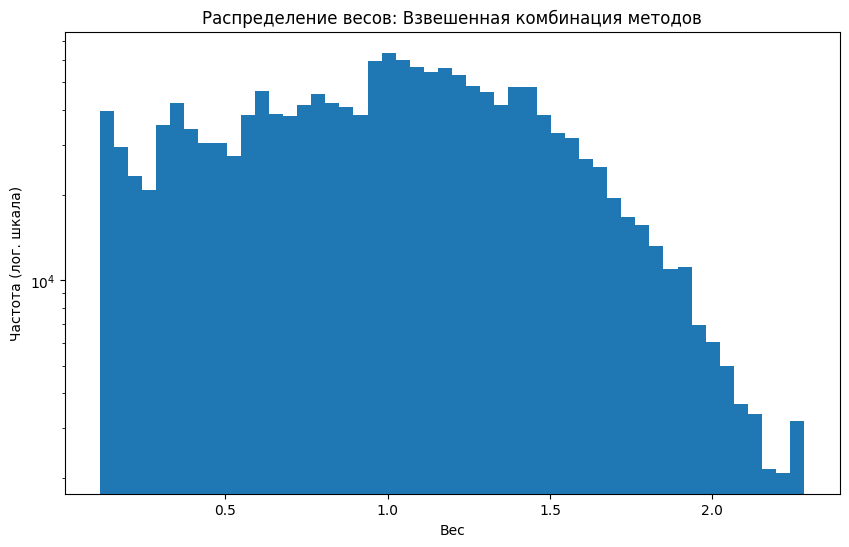

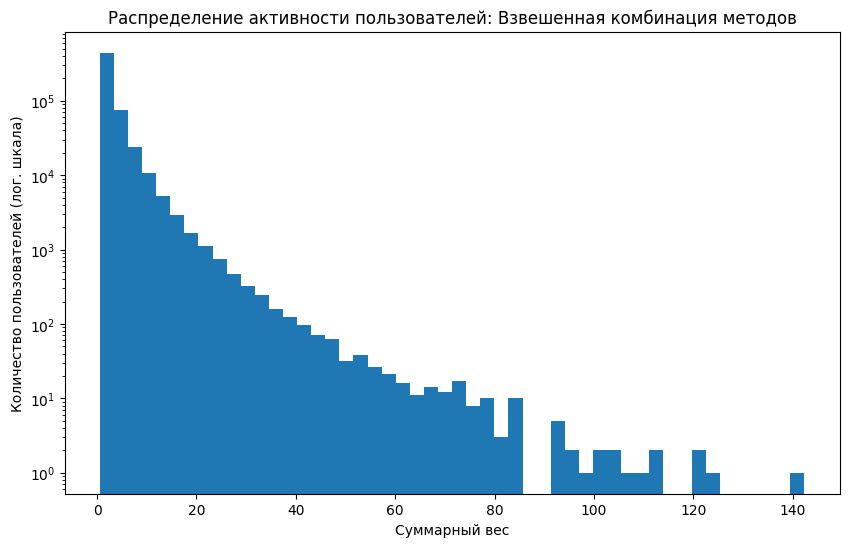

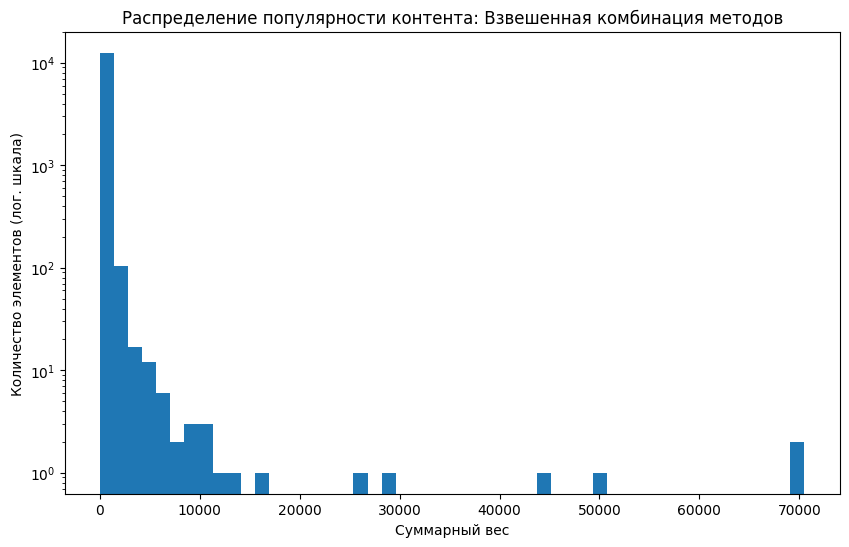

In [ ]:
# веса методов по их уникальности
method_weights = {
    'time_decay': 0.4,
    'completion': 0.4,
    'combined': 0.2         # меньший вес из-за корреляции с другими подходами
}


interactions['weighted_combination'] = (
    method_weights['time_decay'] * interactions['time_decay_weight'] +
    method_weights['completion'] * interactions['completion_weight'] +
    method_weights['combined'] * interactions['normalized_weight'].fillna(0)
)

# нормализуем итоговые веса
final_weights = interactions['weighted_combination'] / interactions['weighted_combination'].sum() * len(interactions)

weighted_matrix = create_and_analyze_matrix(
    final_weights.values,
    "Взвешенная комбинация методов"
)

save_npz('final_weighted_matrix.npz', weighted_matrix)

In [ ]:
# маппинги пользователей и элементов
with open('user_to_index.pkl', 'wb') as f:
    pickle.dump(user_to_index, f)

with open('item_to_index.pkl', 'wb') as f:
    pickle.dump(item_to_index, f)

# информация о методах кодирования
encoding_info = {
    'selected_methods': optimal_methods,
    'method_weights': method_weights,
    'matrix_shapes': {name: matrix.shape for name, matrix in zip(optimal_methods, multi_feature_matrix)},
    'correlation_insights': {
        'time_completion_corr': -0.081,
        'time_combined_corr': 0.079,
        'completion_combined_corr': 0.138
    }
}

with open('encoding_info.pkl', 'wb') as f:
    pickle.dump(encoding_info, f)

print("Метаданные сохранены!")

Метаданные сохранены!


📁 kion_matrix_encoding/

<pre>
├── 📊 Данные:
│   ├── interactions.csv
│   └── items.csv
│
├── 🔢 Матрицы:
│   ├── binary_matrix.npz
│   ├── frequency_matrix.npz
│   ├── frequency_matrix_log.npz
│   ├── time_matrix.npz
│   ├── completion_matrix.npz
│   ├── combined_matrix.npz
│   ├── content_matrix.npz
│   ├── cluster_matrix.npz
│   ├── multi_feature_matrix.npz
│   └── final_weighted_matrix.npz
│
├── 📋 Метаданные:
│   ├── matrix_index.pkl
│   ├── user_to_index.pkl
│   ├── item_to_index.pkl
│   └── encoding_info.pkl
│
└── 📈 Анализ:
    ├── correlation_analysis.png
    └── final_comparison.png
</pre>